In [1]:
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from monolayer_tracking import utils as mt_utils
from scipy.interpolate import LinearNDInterpolator
from pathlib import Path

In [2]:
from cellpose import models, io
from monolayer_tracking.preprocessing import normalize
from scipy.ndimage import gaussian_filter
from monolayer_tracking.preprocessing import gaussian_parallel
from tqdm.notebook import tqdm
from monolayer_tracking import preprocessing
from cellpose import utils as cp_utils
from matplotlib import patheffects
from glob import glob
from natsort import natsorted
from monolayer_tracking.segmented_comprehension import Image

plt.style.use('dark_background')

# write STG from bounding box

In [12]:
input=r"Z:\Andy\raw_data\20240622 FUCCI halo\ME\tilebounds.STG"
output=None
use_colonies='all'
x_spacing=145
y_spacing=205
padding=np.array([335,500])
verbose=True

(130095.8, 133642.2, 35138.5, 40671.5)

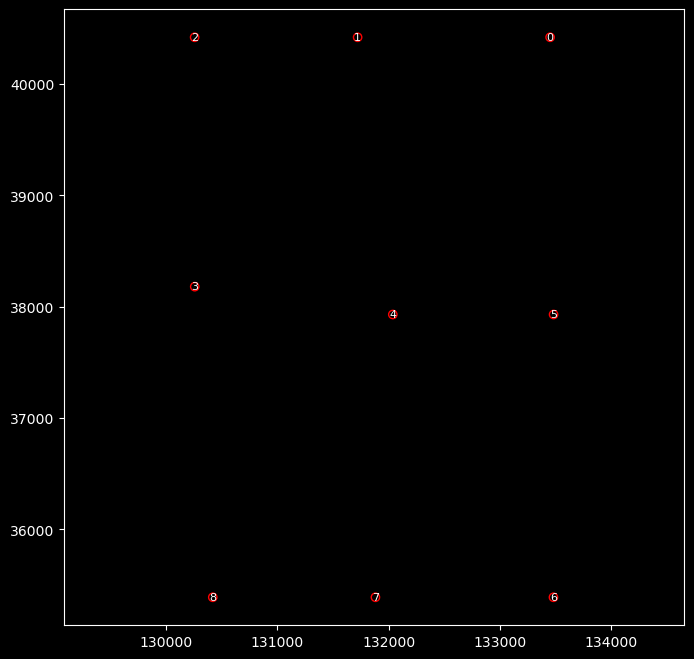

In [13]:
if not output:
    output=input.replace('.STG', '_tiled.STG')

plt.figure(figsize=(8,8))
head, points=mt_utils.read_STG(input)
plt.scatter(points['x'], points['y'], fc='none', ec='r')
for i, txt in enumerate(points.index):
    plt.annotate(txt, (points['x'][i], points['y'][i]), fontsize=8, color='white', ha='center', va='center')

plt.axis('equal')

In [14]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

In [15]:
colony_points=1
num_colonies=len(points)//colony_points
if num_colonies*colony_points<len(points):
    print(f'Warning: {len(points)} points is not a multiple of {colony_points}. Dropping {len(points)%colony_points} points.')
slide_regions=np.array_split(points, num_colonies)

boundary_points=[0,0]#[1,-2]
tiled=[]
for n, slide_bounds in enumerate(slide_regions):
    xmin, xmax=slide_bounds['x'].sort_values().iloc[boundary_points]
    ymin, ymax=slide_bounds['y'].sort_values().iloc[boundary_points]

    max_corner=pd.Series({'x': xmax, 'y': ymax})
    min_corner=pd.Series({'x': xmin, 'y': ymin})

    z_position=slide_bounds['current_z'].mean()

    tile_centers=mt_utils.grid_from_bbox(min_corner, max_corner, x_spacing, y_spacing, padding, reorder=False)

    # Assign z positions, etc. to each stage position via interpolation
    if len(slide_bounds)==1:
        interpolator=NearestNDInterpolator(slide_bounds[['x', 'y']], slide_bounds[['current_z','AF_offset']])
    else:
        interpolator=LinearNDInterpolator(slide_bounds[['x', 'y']], slide_bounds[['current_z','AF_offset']])
        
    z, AF=interpolator(tile_centers[['x', 'y']]).T
    tile_centers['current_z']=np.round(z,2)
    tile_centers['starting_z']=tile_centers['current_z']
    tile_centers['AF_offset']=AF.astype(int)
    tile_centers['position']=f'Region{n+1}'
    tile_centers['stage_number']=[f'_{i}' for i in range(1, len(tile_centers)+1)]
    tile_centers[['FALSE','-9999', 'TRUE_1', 'TRUE_2', '0', '-1', 'endline']]=np.array(slide_bounds[['FALSE', '-9999', 'TRUE_1', 'TRUE_2', '0', '-1', 'endline']])[0]
    tiled.append(tile_centers)
    
tiled=pd.concat(tiled)

c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


144


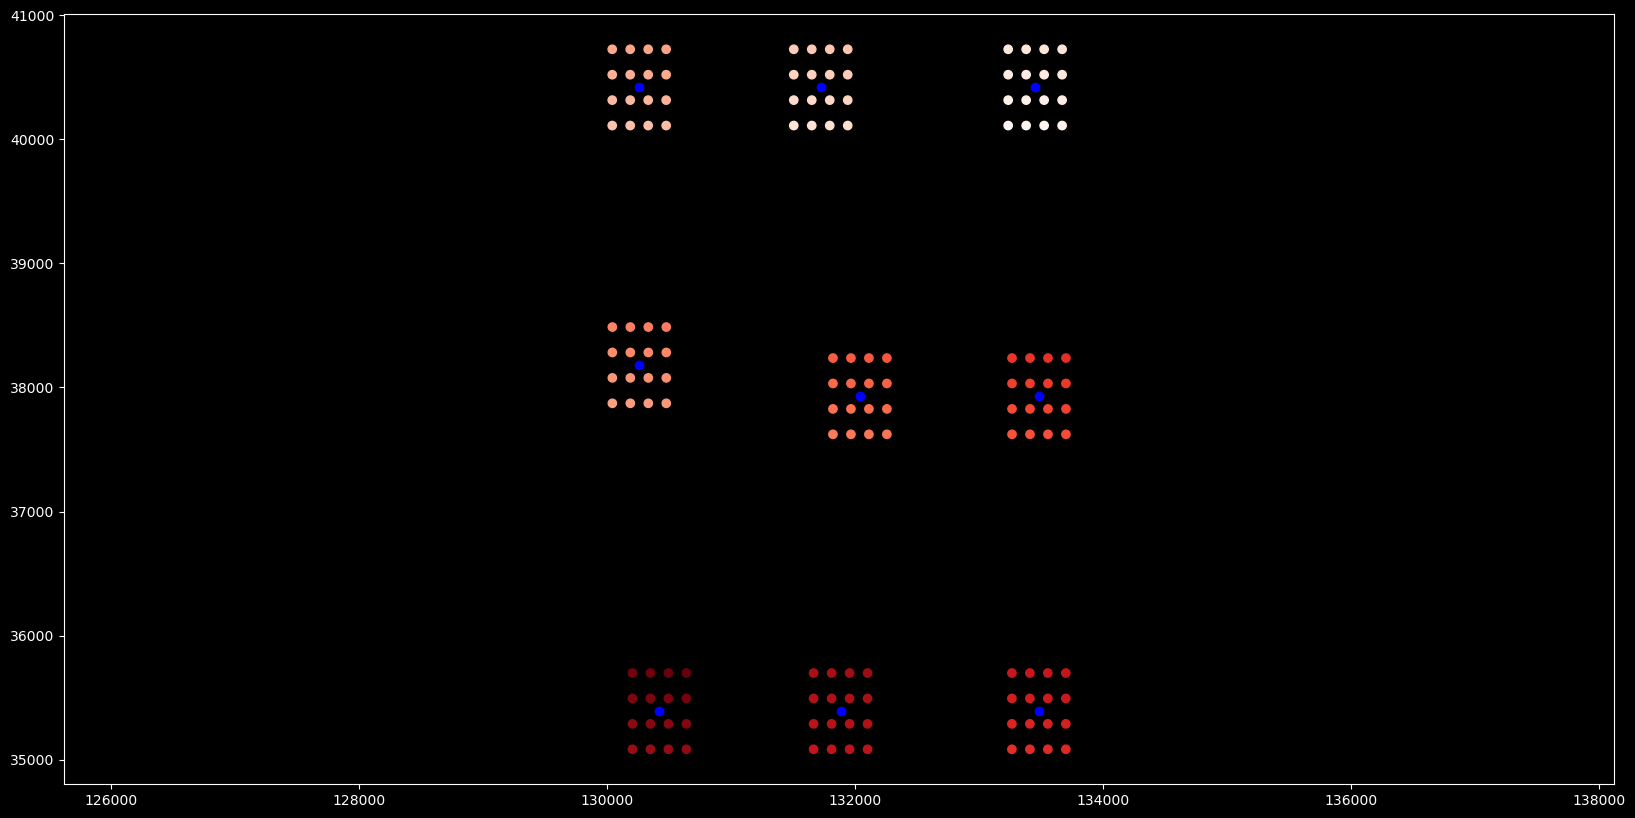

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(tiled['x'], tiled['y'], c=range(len(tiled)), cmap='Reds')
#for i, txt in enumerate(tiled.index):
#    plt.annotate(txt, (tiled['x'][i], tiled['y'][i]))
plt.scatter(points['x'], points['y'], c='b')
plt.axis('equal')
print(len(tiled))

In [17]:
tiled['position']=tiled['position']+tiled['stage_number'] # unique name for each stage position
tiled=tiled[points.columns] # reorder columns for exporting tiled
head[-1]=f'{len(tiled)}\n'
mt_utils.write_STG(output, head, tiled)

In [11]:
mt_utils.write_STG(r'D:\tilebounds_tiled.STG', head, tiled)

# segment

In [49]:
# my mosaic data
imgs=io.imread(r'F:\my_data\Data\20240413 FUCCI_halo_40x suspension\SC_RGB.tif')
model=models.CellposeModel(gpu=True, model_type='cyto3')
diameter=80
output_path=r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\segmented\SC/'
Path(output_path).mkdir(exist_ok=True, parents=True)

for i, img in enumerate(tqdm(imgs)):
    masks=model.eval(img[2], diameter=diameter)[0]
    masks=cp_utils.remove_edge_masks(masks)
    outlines=cp_utils.masks_to_outlines(masks)
    outlines_list=cp_utils.outlines_list(masks)
    export={'img':img, 'masks':masks, 'outlines':outlines, 'outlines_list':outlines_list}
    np.save(output_path+f'SC_{i}.npy', export)

  0%|          | 0/700 [00:00<?, ?it/s]

In [4]:
folder_path=r'F:\Heather\FUCCI\suspended\04262024ME treatments\tifs'
folders=natsorted(glob(folder_path+'/*'))
output_path=Path(folder_path.replace('tifs','segmented'))
output_path.mkdir(exist_ok=True, parents=True)
model=models.CellposeModel(gpu=True, model_type='cyto3')
diameter=23

for treatment in tqdm(folders, desc='treatment'):
    files=natsorted(glob(treatment+'/*.tif'))
    stem=Path(treatment).stem
    for i, img_path in enumerate(tqdm(files, desc=stem)):
        #output_folder=Path(img_path.replace('split','segmented')).parent
        output_folder=Path(output_path/stem)
        output_folder.mkdir(exist_ok=True, parents=True)
        img=io.imread(img_path)
        img=np.array([img[1], img[2], img[0]]) # re-order channels, discard DAPI if it's the fourth channel
        masks=model.eval(img, diameter=diameter, channels=[3,0])[0]
        masks=cp_utils.remove_edge_masks(masks)
        outlines=cp_utils.masks_to_outlines(masks)
        outlines_list=cp_utils.outlines_list(masks)
        export={'img':img, 'masks':masks, 'outlines':outlines, 'outlines_list':outlines_list}
        np.save(output_folder/f'{stem}-{i}_seg.npy', export)

treatment:   0%|          | 0/7 [00:00<?, ?it/s]

no treatment200k:   0%|          | 0/30 [00:00<?, ?it/s]

notreatment100k:   0%|          | 0/30 [00:00<?, ?it/s]

ouabain200k:   0%|          | 0/48 [00:00<?, ?it/s]

phenformin200k:   0%|          | 0/48 [00:00<?, ?it/s]

pnd200k:   0%|          | 0/30 [00:00<?, ?it/s]

sch777200k:   0%|          | 0/30 [00:00<?, ?it/s]

xmu200k:   0%|          | 0/48 [00:00<?, ?it/s]

In [194]:
test_img=Image(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\sch77\sch77-15_seg.npy')
test_img.masks.shape

(488, 488)

In [196]:
test_img.name

'F:\\Heather\\FUCCI\\suspended\\04252024 SC treatments and ycomp bum dilutions\\segmented\\sch77\\sch77-15_seg.npy'

In [198]:
sch77.frames[14].name

'F:\\Heather\\FUCCI\\suspended\\04252024 SC treatments and ycomp bum dilutions\\segmented\\sch77\\sch77-14_seg.npy'

In [28]:
io.imread(files[0]).shape

(4, 488, 488)

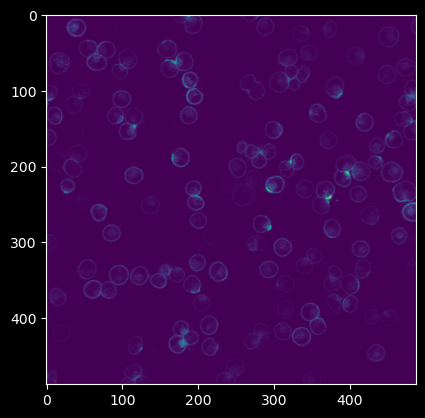

In [25]:
plt.imshow(io.imread(img_path))

# analyze

## get volumes

In [58]:
seg_files=natsorted(glob(r'F:\Heather\FUCCI\suspended\20240419\segmented\Notreatment\dish1'+'/*.npy'))

In [21]:
from scipy import ndimage

In [59]:
seg_files

['F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-0_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-1_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-2_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-3_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-4_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-5_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-6_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-7_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-8_seg.npy',
 'F:\\Heather\\FUCCI\\suspended\\20240419\\segmented\\Notreatment\\dish1\\Notreatment-9_seg.npy',
 'F:\\Heather\\FUCCI

In [37]:
frame=Image(seg_files[-3], scale=0.6905357, load_img=True)
red=frame.img[0]
green=frame.img[1]
membrane=frame.img[2]

red=normalize(ndimage.gaussian_filter(red, 3))
green=normalize(ndimage.gaussian_filter(green, 3))

In [38]:
red_threshold=0.2
green_threshold=0.2

thresholded_red=red>red_threshold
thresholded_green=green>green_threshold
thresholded_orange=(red>red_threshold*1.5)&thresholded_green

In [84]:
class SuspendedDataset:
    def __init__(self, path, scale=0.16125, preprocess_FUCCI=True, blur_sigma=5, **kwargs):
        self.name=path
        self.frame_paths=natsorted(glob(path+'/*.npy'))
        self.frames=[Image(frame_path, frame_number=n, scale=scale, load_img=True, **kwargs) for n, frame_path in enumerate(tqdm(self.frame_paths, desc='loading images'))]
        self.scale=scale

        red, green, membrane=[],[],[]
        for frame in self.frames:
            red.append(frame.img[0])
            green.append(frame.img[1])
            membrane.append(frame.img[2])
        self.red=np.array(red)
        self.green=np.array(green)
        self.membrane=np.array(membrane)

        if preprocess_FUCCI:
            self.red, self.green=self._normalize_FUCCI(*self._blur_FUCCI(blur_sigma))

    def _blur_FUCCI(self, sigma=5):
        red=gaussian_parallel(self.red, sigma=sigma, progress_bar=tqdm)
        green=gaussian_parallel(self.green, sigma=sigma, progress_bar=tqdm)
        return np.array(red), np.array(green)
    
    def _normalize_FUCCI(self, red, green):
        red=normalize(red.flatten()).reshape(red.shape)
        green=normalize(green.flatten()).reshape(green.shape)
        return red, green

    def measure_FUCCI(self, red_threshold=0.3, green_threshold=0.3, orange_brightness=1.5, percent_threshold=0.15):
        thresholded_red=self.red>red_threshold
        thresholded_green=self.green>green_threshold
        thresholded_orange=(self.red>red_threshold*orange_brightness)&thresholded_green # orange cells have to be bright red
        self.red_threshold=red_threshold
        self.green_threshold=green_threshold

        cc_stages=preprocessing.parallel_frame_FUCCI(list(zip([frame.masks for frame in self.frames], thresholded_red, thresholded_green, thresholded_orange)), progress_bar=tqdm, percent_threshold=percent_threshold)
        self.cc_stages=cc_stages
        return self.cc_stages
    
    def get_outlines(self, progress_bar=tqdm):
        from multiprocessing import Pool

        if progress_bar is None:
            progress_bar=lambda x: x
            progress_kwargs={}
        else:
            progress_kwargs={'total':len(self.frames),'desc':'Getting outlines'}
        p=Pool(8)
        self.outlines=[x for x in progress_bar(p.imap(cp_utils.outlines_list, [frame.masks for frame in self.frames]), **progress_kwargs)]
        return self.outlines
    
    def get_volumes(self, circ_threshold=0.85):
        if not hasattr(self, 'cc_stages'):
            self.measure_FUCCI()
        if not hasattr(self, 'outlines'):
            self.get_outlines()
        
        all_outlines=[outline for outlines in self.outlines for outline in outlines]
        all_cc_stages=np.concatenate(self.cc_stages)

        circs=np.array([polyCircularity(*np.array(outline).T) for outline in all_outlines])
        circular_outlines=[all_outlines[i] for i in np.where(circs>circ_threshold)[0]]
        circular_cc=[all_cc_stages[i] for i in np.where(circs>circ_threshold)[0]]

        volumes=[]
        for stage in tqdm(range(4), desc='Calculating volumes'):
            volumes.append(np.array([polyVolume(*np.array(outline).T) for i, outline in enumerate(circular_outlines) if circular_cc[i]==stage])*self.scale**3)
        self.volumes=volumes
        return self.volumes
    
    def show_FUCCI(self, idx, circ_threshold=0.85):
        plt.imshow(np.stack([self.red[idx], self.green[idx], np.zeros_like(self.red[idx])], axis=-1))
        
        # annotate cell numbers
        if not hasattr(self, 'cc_stages'):
            self.measure_FUCCI()
        if not hasattr(self, 'outlines'):
            self.get_outlines()

        cc_stages=self.cc_stages[idx]
        outlines=cp_utils.outlines_list(self.frames[idx].masks)
        colors=['white','g','r','orange']
        for i, (cell_number, cc, o) in enumerate(zip(np.unique(self.frames[idx].masks)[1:], cc_stages, outlines)):
            if polyCircularity(*np.array(o).T)<circ_threshold:
                plt.plot(*o.T, c='gray', lw=0.5)
                continue
            #centroid=np.mean(np.argwhere(self.frames[idx].masks==cell_number), axis=0)
            plt.plot(*o.T, c=colors[cc], lw=0.5)
            # outline text
            #label=plt.text(*centroid[::-1], f'{cc}', ha='center', va='center', fontsize=8, color='w')
            #label.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        return self.frames[idx]
    
def polyPerimeter(x,y):
    return np.sum(np.sqrt(np.diff(x)**2+np.diff(y)**2)) 

def polyCircularity(x,y):
    return 4*np.pi*polyArea(x,y)/polyPerimeter(x,y)**2

def polyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def volume_from_area(area):
    # spherical volume from circular area
    return 4/3*np.pi*(area/np.pi)**1.5

def polyVolume(x,y):
    return volume_from_area(polyArea(x,y))

In [8]:
path_ME=r'F:\Heather\FUCCI\suspended\04262024ME treatments\segmented'
WT=SuspendedDataset(path_ME+'/no treatment200k', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
ouabain=SuspendedDataset(path_ME+'/ouabain200k', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
phenformin=SuspendedDataset(path_ME+'/phenformin200k', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
pnd=SuspendedDataset(path_ME+'/pnd200k', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
sch777=SuspendedDataset(path_ME+'/sch777200k', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
xmu=SuspendedDataset(path_ME+'/xmu200k', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)

loading images:   0%|          | 0/30 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/30 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/30 [00:00<?, ?it/s]

loading images:   0%|          | 0/48 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/48 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/48 [00:00<?, ?it/s]

loading images:   0%|          | 0/48 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/48 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/48 [00:00<?, ?it/s]

loading images:   0%|          | 0/30 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/30 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/30 [00:00<?, ?it/s]

loading images:   0%|          | 0/30 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/30 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/30 [00:00<?, ?it/s]

loading images:   0%|          | 0/48 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/48 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/48 [00:00<?, ?it/s]

In [21]:
datasets=[WT, ouabain, phenformin, pnd, sch777, xmu]
labels=['WT', 'ouabain', 'phenformin', 'pnd', 'sch777', 'xmu']

In [38]:
volume_folder=r'F:\Heather\FUCCI\suspended\04262024ME treatments\volumes'
for dataset, label in zip(datasets, labels):
    pd.to_pickle(dataset.volumes, volume_folder+f'/{label}.pkl')

In [99]:
WT_dilution=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\sccontrol_dilplate', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
bum10um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\10umbum', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
bum33um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\33umbum', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
ycomp10um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\10umycomp', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
ycomp33um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\33umycomp', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)

loading images:   0%|          | 0/40 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/40 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/40 [00:00<?, ?it/s]

loading images:   0%|          | 0/50 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/50 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/50 [00:00<?, ?it/s]

loading images:   0%|          | 0/49 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/49 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/49 [00:00<?, ?it/s]

loading images:   0%|          | 0/35 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/35 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/35 [00:00<?, ?it/s]

loading images:   0%|          | 0/50 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/50 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/50 [00:00<?, ?it/s]

In [100]:
WT=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\sccontrol', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
rapamycin=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\Rapamycin', scale=0.3452677, preprocess_FUCCI=True, blur_sigma=2)
sch77=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\sch77', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
low_serum=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\2percfbs', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)

loading images:   0%|          | 0/25 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/25 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/25 [00:00<?, ?it/s]

loading images:   0%|          | 0/72 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/72 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/72 [00:00<?, ?it/s]

loading images:   0%|          | 0/72 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/72 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/72 [00:00<?, ?it/s]

loading images:   0%|          | 0/72 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/72 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/72 [00:00<?, ?it/s]

In [85]:
WT=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\Notreatment\dish1', scale=0.6905357, blur_sigma=2)
bum1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\bum\dish1', scale=0.6905357, blur_sigma=2)
bum2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\bum\dish2', scale=0.6905357, blur_sigma=2)
PND1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\PND\dish1', scale=0.6905357, blur_sigma=2)
PND2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\PND\dish2', scale=0.6905357, blur_sigma=2)
rapamycin1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\rapamycin\dish1', scale=0.6905357, blur_sigma=2)
rapamycin2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\rapamycin\dish2', scale=0.6905357, blur_sigma=2)
sch771=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\sch77\dish1', scale=0.6905357, blur_sigma=2)
sch772=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\sch77\dish2', scale=0.6905357, blur_sigma=2)
ycomp1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\ycomp\dish1', scale=0.6905357, blur_sigma=2)
ycomp2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\ycomp\dish2', scale=0.6905357, blur_sigma=2)

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

loading images:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
SC_0413=SuspendedDataset(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\segmented\SC')

loading images:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

In [7]:
ME_0413=SuspendedDataset(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\segmented\ME')

loading images:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

computing gaussians:   0%|          | 0/700 [00:00<?, ?it/s]

In [ ]:
Heather_SC=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240410\segmented/', scale=0.3452677)

In [ ]:
SC_0407=SuspendedDataset(r'F:\my_data\Segmentation\20240407 FUCCI suspension\segmented\SC/')

In [ ]:
SC_0411=SuspendedDataset(r'F:\my_data\Segmentation\20240411 FUCCI suspension\segmented\SC/')

In [ ]:
ME_0412=SuspendedDataset(r'F:\my_data\Segmentation\20240412 FUCCI_halo_40x suspension ME\segmented\ME/')

In [ ]:
#ME2_0415=SuspendedDataset(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\segmented\suspension2/')
ME1_0415=SuspendedDataset(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\segmented\suspension1/')

### Check thresholds

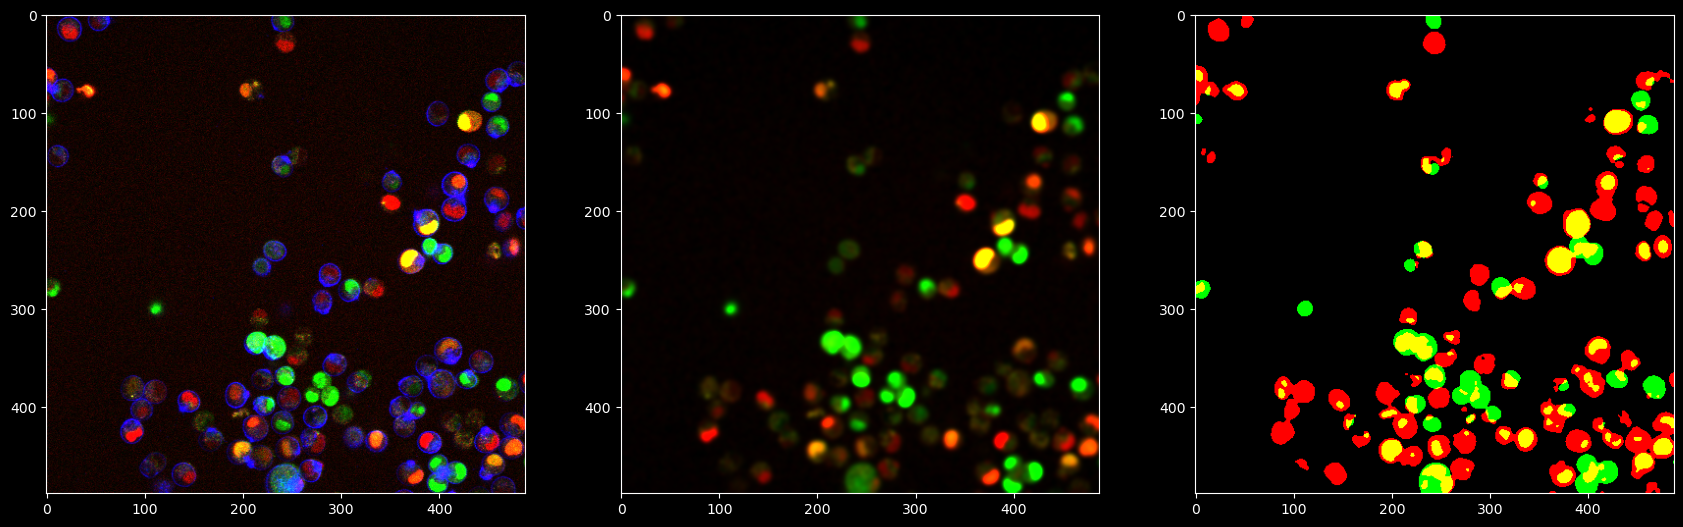

In [119]:
# visualize blurring, thresholding
n=0
to_plot=low_serum

fig, axes=plt.subplots(1,3, figsize=(21,20))
axes[0].imshow(preprocessing.normalize(to_plot.frames[n].img.transpose(1,2,0)))

color_FUCCI=np.stack([to_plot.red[n], to_plot.green[n], np.zeros_like(to_plot.red[n])], axis=-1)
axes[1].imshow(color_FUCCI)

threshold_FUCCI=np.stack([to_plot.red[n]>0.1, to_plot.green[n]>0.15, np.zeros_like(to_plot.red[n])], axis=-1)
axes[2].imshow(threshold_FUCCI)

In [ ]:
ycomp10um.measure_FUCCI(red_threshold=0.15, green_threshold=0.25, orange_brightness=1.5, percent_threshold=0.15)
ycomp33um.measure_FUCCI(red_threshold=0.25, green_threshold=0.25, orange_brightness=1.5, percent_threshold=0.15)

In [ ]:
ycomp10um.get_volumes()
ycomp33um.get_volumes()

In [109]:
datasets=[WT_dilution, bum10um, bum33um, ycomp10um, ycomp33um, WT, rapamycin, sch77, low_serum]
labels=['WT_dilution', 'bum10um', 'bum33um', 'ycomp10um', 'ycomp33um', 'WT', 'rapamycin', 'sch77', 'low_serum']

In [107]:
for dataset in tqdm(datasets, desc='datasets'):
    dataset.measure_FUCCI(red_threshold=0.1, green_threshold=0.15, orange_brightness=1.5, percent_threshold=0.15)
    dataset.get_volumes()

datasets:   0%|          | 0/9 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/40 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/50 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/49 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/49 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/35 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/35 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/50 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/25 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/25 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/72 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/72 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/72 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [91]:
# get FUCCI, measure volumes
for dataset in tqdm(datasets, desc='datasets'):
    dataset.measure_FUCCI(red_threshold=0.15, green_threshold=0.15, orange_brightness=1.5, percent_threshold=0.15)
    dataset.get_volumes()

datasets:   0%|          | 0/11 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [137]:
# get FUCCI, measure volumes
for dataset in tqdm([WT, rapamycin, sch77, low_serum]):
    dataset.measure_FUCCI(red_threshold=0.15, green_threshold=0.15, orange_brightness=1.5, percent_threshold=0.15)
    dataset.get_volumes()

  0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/25 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/25 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/72 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/72 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/72 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [92]:
WT_vols=WT.volumes
bum1_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(bum1.volumes, bum2.volumes)]
PND_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(PND1.volumes, PND2.volumes)]
rapamycin_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(rapamycin1.volumes, rapamycin2.volumes)]
sch77_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(sch771.volumes, sch772.volumes)]
ycomp_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(ycomp1.volumes, ycomp2.volumes)]

In [98]:
pd.to_pickle(WT_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\WT.pkl')
pd.to_pickle(bum1_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\bum.pkl')
pd.to_pickle(PND_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\PND.pkl')
pd.to_pickle(rapamycin_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\rapamycin.pkl')
pd.to_pickle(sch77_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\sch77.pkl')
pd.to_pickle(ycomp_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\ycomp.pkl')

In [120]:
for dataset, label in zip(datasets, labels):
    pd.to_pickle(dataset.volumes, r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\volumes'+f'/{label}.pkl')

In [268]:
# export FUCCI labels for verification
to_plot=ycomp2
for n in tqdm(range(len(to_plot.frames)), desc='drawing frame'):
    fig=plt.figure(figsize=(10,5))
    ax_0=fig.add_subplot(121)
    to_plot.show_FUCCI(n)
    ax_0.set_title('segmented and labeled FUCCI')
    ax_1=fig.add_subplot(122)
    ax_1.imshow(np.stack([to_plot.red[n]>to_plot.red_threshold, to_plot.green[n]>to_plot.green_threshold, np.zeros_like(to_plot.red[n])], axis=-1))
    ax_1.set_title('binarized')
    plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\frames\ycomp/'+f'ycomp2_{n}.jpg',dpi=300, bbox_inches='tight')
    plt.close()

drawing frame:   0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
SC_0413.get_volumes()
pd.to_pickle(SC_0413.volumes, r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\SC.pkl')

ME_0413.get_volumes()
pd.to_pickle(ME_0413.volumes, r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\ME.pkl')

Getting outlines:   0%|          | 0/700 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/700 [00:00<?, ?it/s]

C:\Users\Andy\AppData\Local\Temp\ipykernel_19096\2485897937.py:108: RuntimeWarning: invalid value encountered in scalar divide
  return 4*np.pi*polyArea(x,y)/polyPerimeter(x,y)**2


Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

## volume statistics

In [220]:
vol_0412_ME=pd.read_pickle(r'F:\my_data\Segmentation\20240412 FUCCI_halo_40x suspension ME\volumes\ME.pkl')
vol_0411_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240411 FUCCI suspension\volumes\SC.pkl')
vol_0415_ME1=pd.read_pickle(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\volumes\suspension1.pkl')
vol_0415_ME2=pd.read_pickle(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\volumes\suspension2.pkl')

In [225]:
vol_Heather_SC=pd.read_pickle(r'F:\Heather\FUCCI\suspended\20240410\volumes\SC.pkl')
vol_0407_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240407 FUCCI suspension\volumes\SC.pkl')
vol_0413_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\SC.pkl')
vol_0413_ME=pd.read_pickle(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\ME.pkl')

### Occupancy barplot

In [94]:
# bar plots of cell cycle stage distributions
def cc_occupancy(vol):
    return [len(v)/len(np.concatenate(vol)) for v in vol]

def multi_barplot(vols, labels, ax=None, hatching=False, xticks=['NS', 'G1', 'S', 'G2'], **kwargs):
    if not ax:
        ax=plt.gca()
        
    num_groups=len(vols)
    width=1/(num_groups+1)

    x=np.arange(len(xticks))

    # if kwargs is not empty, use it to set bar properties
    bar_kwargs=[{} for i in range(num_groups)]
    for key, values in kwargs.items():
        for i, value in enumerate(values):
            bar_kwargs[i][key]=value

    for i, vol in enumerate(vols):
        if hatching:
            if labels[i].startswith('SC'):
                hatching='ooo'
            else:
                hatching='///'
        else:
            hatching=None

        ax.bar(x+i*width, cc_occupancy(vol), width, align='edge', edgecolor='k', hatch=hatching, label=labels[i], **bar_kwargs[i])
    
    plt.xticks(x+width*num_groups/2, xticks) # centered labels
    plt.legend()

Text(0.5, 1.0, 'Cell cycle stage distributions in suspended cells, 20240419')

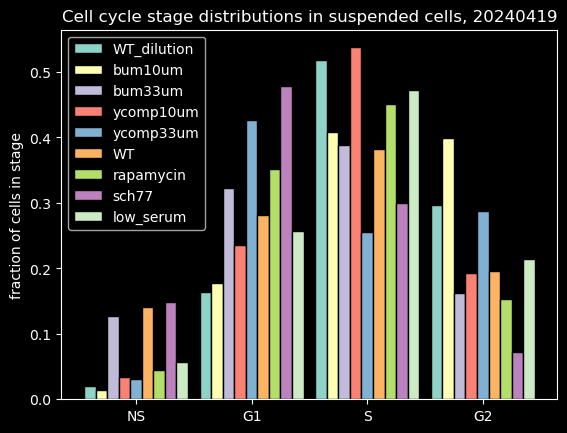

In [118]:
multi_barplot([d.volumes for d in datasets], labels)
plt.ylabel('fraction of cells in stage')
plt.title('Cell cycle stage distributions in suspended cells, 20240419')
#plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\cc_occupancy.jpg', bbox_inches='tight', dpi=300)

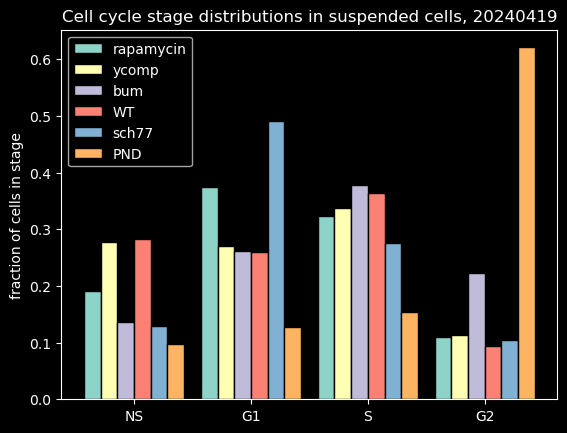

In [ ]:
multi_barplot([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'])
plt.ylabel('fraction of cells in stage')
plt.title('Cell cycle stage distributions in suspended cells, 20240419')
plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\cc_occupancy.jpg', bbox_inches='tight', dpi=300)

[{}, {}, {}]
[{'color': 'C0'}, {'color': 'C5'}, {'color': 'C6'}]
[{}, {}, {}]
[{'color': 'C0'}, {'color': 'C2'}, {'color': 'C7'}]


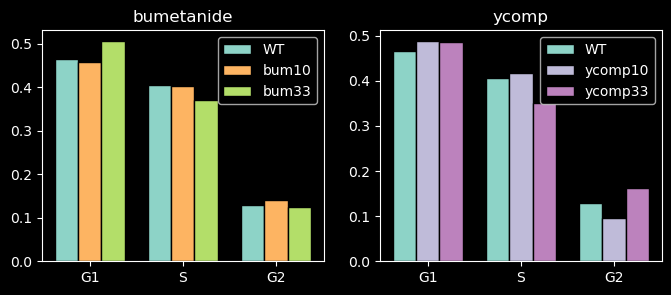

In [246]:
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot(121)
multi_barplot([WT.volumes[1:], bum10um.volumes[1:], bum33um.volumes[1:]], ['WT', 'bum10', 'bum33'], ax=ax, xticks=['G1', 'S', 'G2'], color=['C0', 'C5', 'C6'])
ax.set_title('bumetanide')

ax=fig.add_subplot(122)
multi_barplot([WT.volumes[1:], ycomp10um.volumes[1:], ycomp33um.volumes[1:]], ['WT', 'ycomp10', 'ycomp33'], ax=ax, xticks=['G1', 'S', 'G2'], color=['C0', 'C2', 'C7'])
ax.set_title('ycomp')

plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\dilution_cc_occupancy.jpg', bbox_inches='tight', dpi=300)

[{}, {}, {}, {}]
[{}, {}, {}, {}]


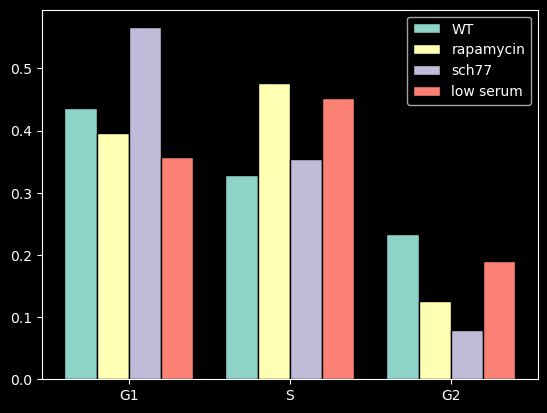

In [215]:
multi_barplot([WT.volumes[1:], rapamycin.volumes[1:], sch77.volumes[1:], low_serum.volumes[1:]], ['WT', 'rapamycin', 'sch77', 'low serum'], xticks=['G1', 'S', 'G2'])
plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\cc_occupancy.jpg', bbox_inches='tight', dpi=300)

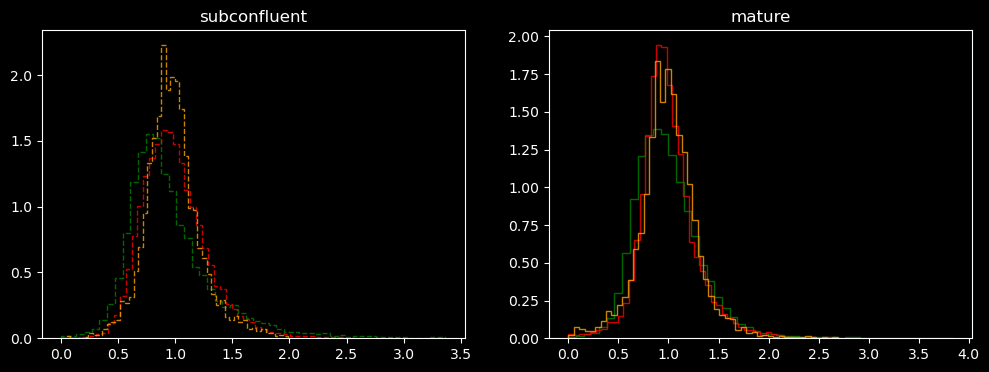

In [245]:
colors=['g','r','orange']
all_ME=[np.concatenate([v1,v2]) for v1, v2 in zip(vol_0412_ME, vol_0415_ME2)]
all_SC=[np.concatenate([v1,v2]) for v1, v2 in zip(vol_0411_SC, vol_0407_SC)]

fig, axes=plt.subplots(1,2,figsize=(12,4))

axes[0].set_title('subconfluent')
axes[1].set_title('mature')

for i, data in enumerate(all_SC[1:]):
    axes[0].hist(data/np.mean(data), bins=50, range=(0,6000/np.mean(data)), density=True, linestyle='--', alpha=0.8, histtype='step', color=colors[i])
for i, data in enumerate(all_ME[1:]):
    axes[1].hist(data/np.mean(data), bins=50, range=(0,6000/np.mean(data)), density=True, alpha=0.8, histtype='step', color=colors[i])

Text(0.5, 1.0, 'suspended cell volumes at SC and ME')

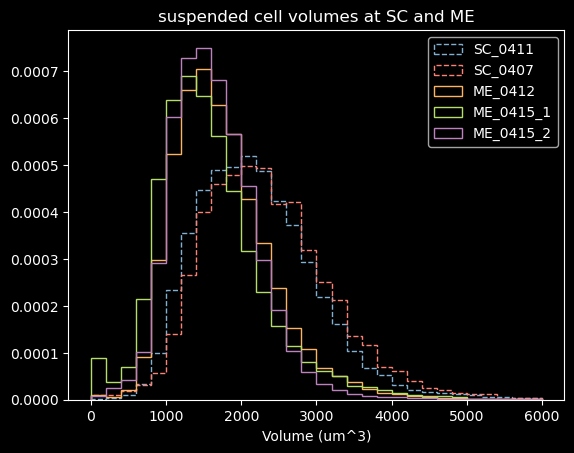

In [271]:
plt.hist(np.concatenate(vol_0411_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0411', color='C4')
plt.hist(np.concatenate(vol_0407_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0407', color='C3')
#plt.hist(np.concatenate(vol_0413_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0413', color='C2')
#plt.hist(np.concatenate(vol_Heather_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='Heather_SC', color='C2')
plt.hist(np.concatenate(vol_0412_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0412', color='C5')
plt.hist(np.concatenate(vol_0415_ME1[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0415_1', color='C6')
plt.hist(np.concatenate(vol_0415_ME2[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0415_2', color='C7')
#plt.hist(np.concatenate(vol_0413_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0413', color='C8')

plt.legend()

plt.xlabel('Volume (um^3)')
plt.title('suspended cell volumes at SC and ME')

#plt.savefig('plots/suspended_volumes/volume_hist.jpg', dpi=300)

Text(0.5, 0, 'volume/<volume>')

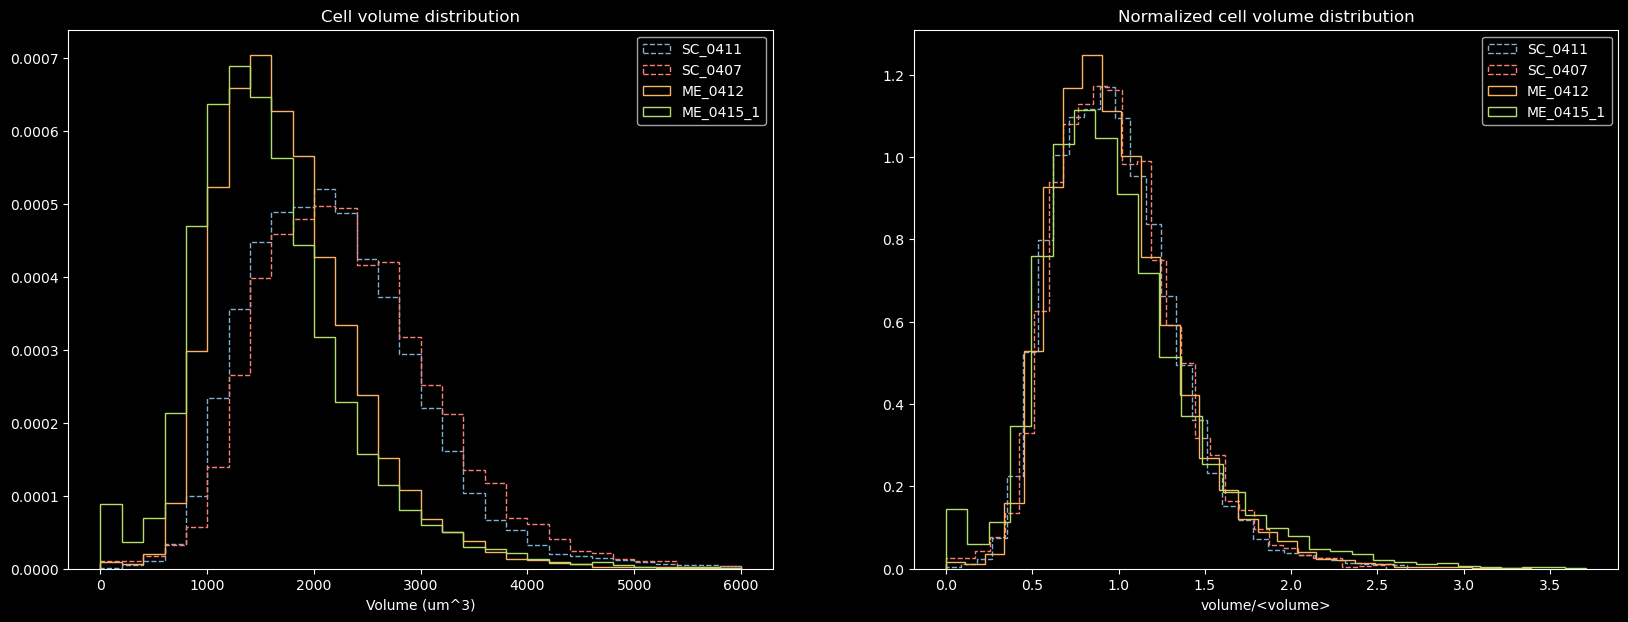

In [35]:
def volume_hist(volumes, ax, normalize=False, label=None, bins=30, range=(0,6000), density=True, histtype='step', **kwargs):
    volumes=np.concatenate(volumes)
    if normalize:
        range=(0, range[1]/np.mean(volumes))
        volumes/=np.mean(volumes)

    if label is not None and label.startswith('SC'):
        linestyle='--'
    else:
        linestyle='-'

    ax.hist(volumes, bins=bins, range=range, density=density, label=label, linestyle=linestyle, histtype=histtype, **kwargs)

fig, axes=plt.subplots(1,2, figsize=(20,7))

volume_hist(vol_0411_SC[1:], axes[0], label='SC_0411', color='C4')
volume_hist(vol_0407_SC[1:], axes[0], label='SC_0407', color='C3')
volume_hist(vol_0412_ME[1:], axes[0], label='ME_0412', color='C5')
volume_hist(vol_0415_ME1[1:], axes[0], label='ME_0415_1', color='C6')

volume_hist(vol_0411_SC[1:], axes[1], label='SC_0411', color='C4', normalize=True)
volume_hist(vol_0407_SC[1:], axes[1], label='SC_0407', color='C3', normalize=True)
volume_hist(vol_0412_ME[1:], axes[1], label='ME_0412', color='C5', normalize=True)
volume_hist(vol_0415_ME1[1:], axes[1], label='ME_0415_1', color='C6', normalize=True)

axes[0].legend()
axes[1].legend()

axes[0].set_title('Cell volume distribution')
axes[1].set_title('Normalized cell volume distribution')

axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('volume/<volume>')

In [ ]:
fig, axes=plt.subplots(1,3, figsize=(20,6))

for vol,label in zip([vol_0411_SC, vol_0413_SC,vol_0412_ME, vol_0415_ME2, vol_0415_ME1], ['SC_0411', 'SC_0413', 'ME_0412', 'ME_0415_2', 'ME_0415_1']):
    if label.startswith('SC'):
        linestyle='--'
    else:
        linestyle='-'
    for ax, v in zip(axes, vol[1:]):
        ax.hist(v, bins=30, range=(0,6000), density=True, histtype='step', linestyle=linestyle, label=label)

axes[2].legend()
axes[0].set_title('G1')
axes[1].set_title('S')
axes[2].set_title('G2')

In [168]:
[len(v) for v in low_serum.volumes]

[1004, 2130, 2700, 1134]

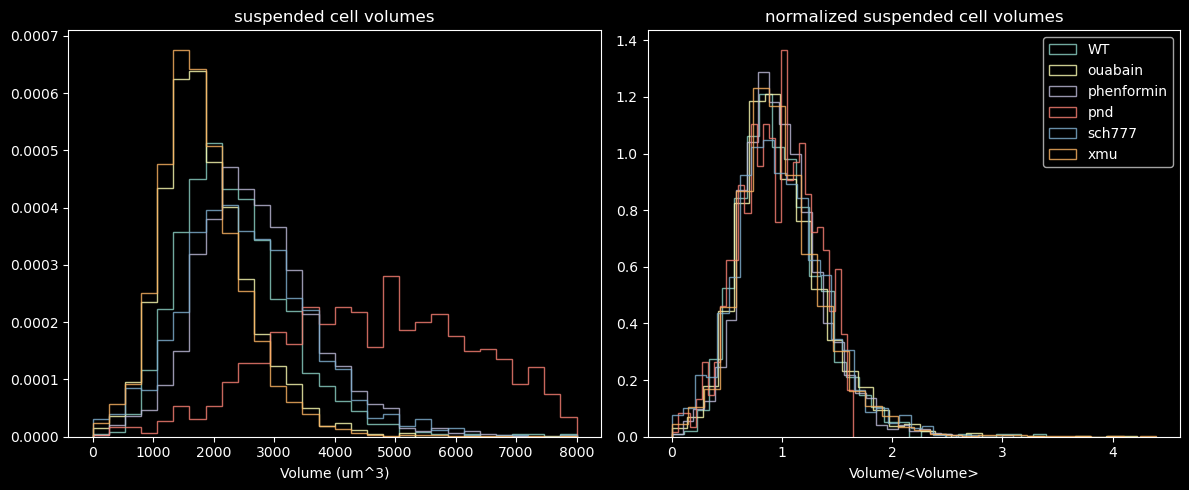

In [40]:
fig, axes=plt.subplots(1,2, figsize=(12,5))

for dataset, label in zip([d.volumes for d in datasets], labels):
    axes[0].hist(np.concatenate(dataset[1:]), range=(0,8000), bins=30, density=True, histtype='step', alpha=0.8, label=label)
    axes[1].hist(np.concatenate(dataset[1:])/np.mean(np.concatenate(dataset[1:])), range=(0,8000/np.mean(np.concatenate(dataset[1:]))), bins=30, density=True, histtype='step', alpha=0.8, label=label)

axes[1].legend()
axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('Volume/<Volume>')
axes[0].set_title('suspended cell volumes')
axes[1].set_title('normalized suspended cell volumes')

fig.tight_layout()
plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\volume_hist.jpg', bbox_inches='tight', dpi=300)

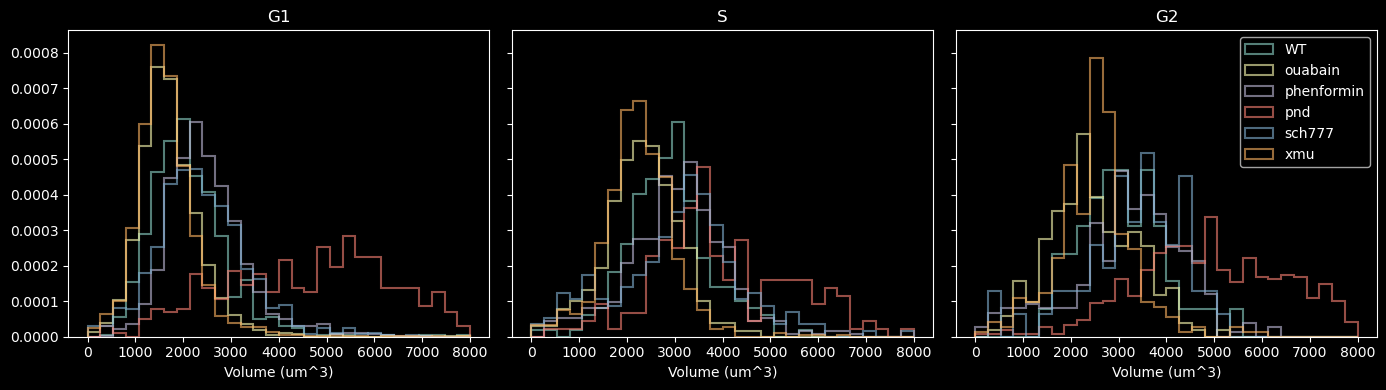

In [41]:
fig, axes=plt.subplots(1,3, figsize=(14,4), sharex=True, sharey=True)
for dataset, label in zip([d.volumes for d in datasets], labels):
    for ax, data in zip(axes, dataset[1:]):
        ax.hist(data, range=(0,8000), bins=30, density=True, histtype='step', alpha=0.6, linewidth=1.5, label=label)

for ax, title in zip(axes, ['G1','S','G2']):
    ax.set_title(title)
    ax.set_xlabel('Volume (um^3)')
    
axes[2].legend()
fig.tight_layout()

plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\cc_volume_hist.jpg', bbox_inches='tight', dpi=300)

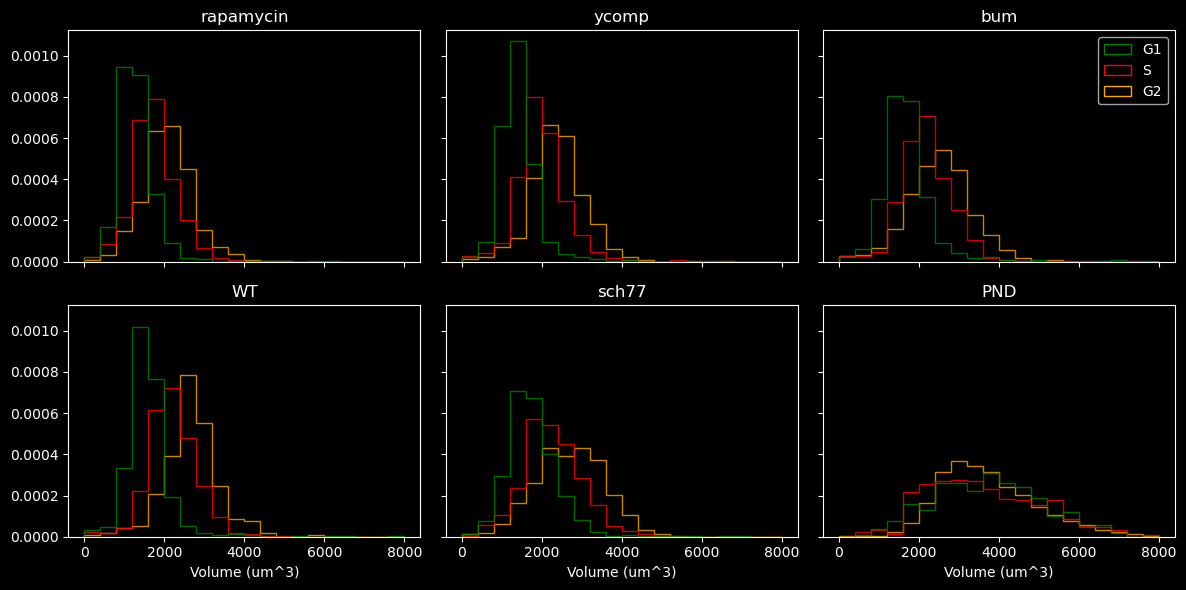

In [209]:
fig, axes=plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True)
for dataset, label, ax in zip([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'], axes.flatten()):
    ax.hist(dataset[1:], range=(0,8000), bins=20, density=True, histtype='step', alpha=0.8, color=['g','r','orange'])
    ax.set_title(label)

for ax in axes[1]:
    ax.set_xlabel('Volume (um^3)')

axes[0,2].bar(0,0, color='k', ec='g', label='G1')
axes[0,2].bar(0,0, color='k', ec='r', label='S')
axes[0,2].bar(0,0, color='k', ec='orange', label='G2')
axes[0,2].legend()

fig.tight_layout()
plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\treatment_volume_hist.jpg', bbox_inches='tight', dpi=300)

In [26]:
def volume_boxplot(vols, labels, ax=None):
    if not ax:
        ax=plt.gca()
    num_groups=len(vols)
    colors=['k','g','r','orange']
    
    for i, vol in enumerate(vols):
        n_samples=[len(v) for v in vol]
        box_labels=[f"{labels[i]}\n n={n}" for n in n_samples]
        bp=ax.boxplot(vol, positions=np.arange(i*5, i*5+4), patch_artist=True, showfliers=False, labels=box_labels)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            
    plt.xticks(rotation=45)
    ax.set_ylabel('volume (um^3)')

In [27]:
print([np.median(v[1]) for v in [d.volumes for d in datasets]])

[1989.0182476102987, 1653.2805928793134, 2392.1485511085, 5008.9596865537715, 2315.420154608444, 1587.2701575873252]


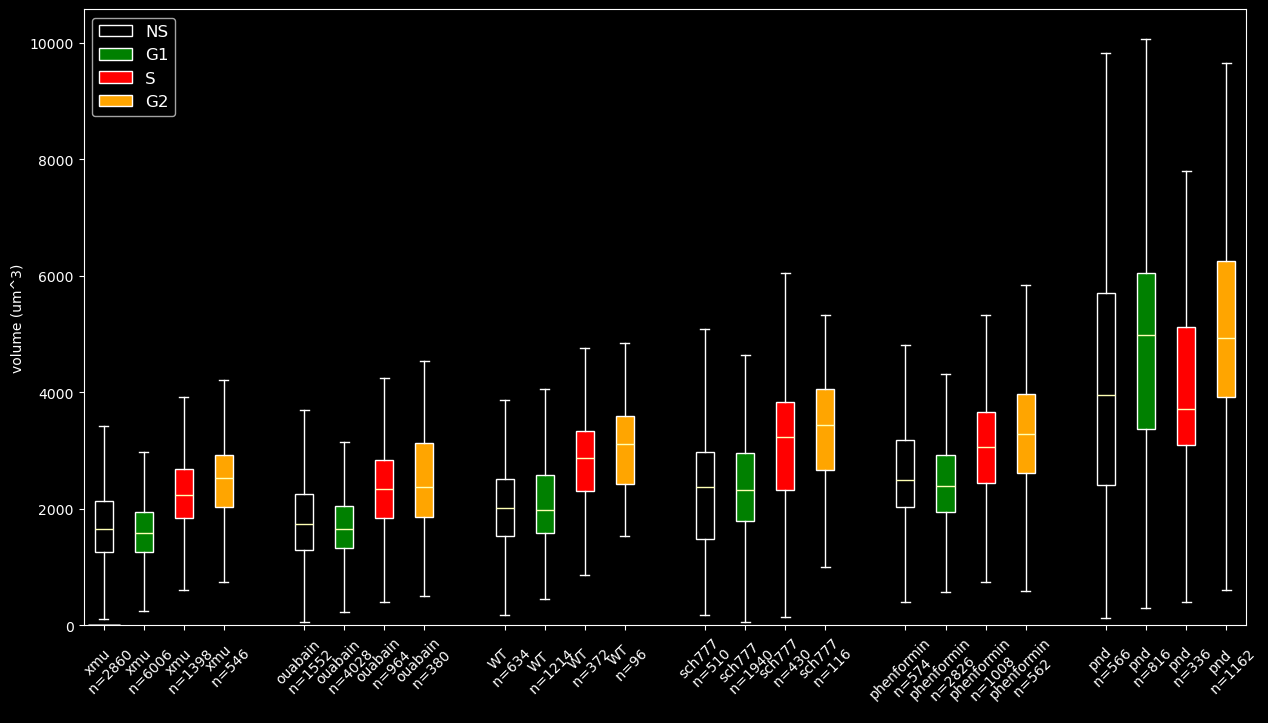

In [42]:
plt.figure(figsize=(15,8))
volume_boxplot([d.volumes for d in [xmu, ouabain, WT, sch777, phenformin, pnd]], ['xmu','ouabain','WT','sch777','phenformin','pnd'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\volume_boxplot.jpg', bbox_inches='tight', dpi=300)

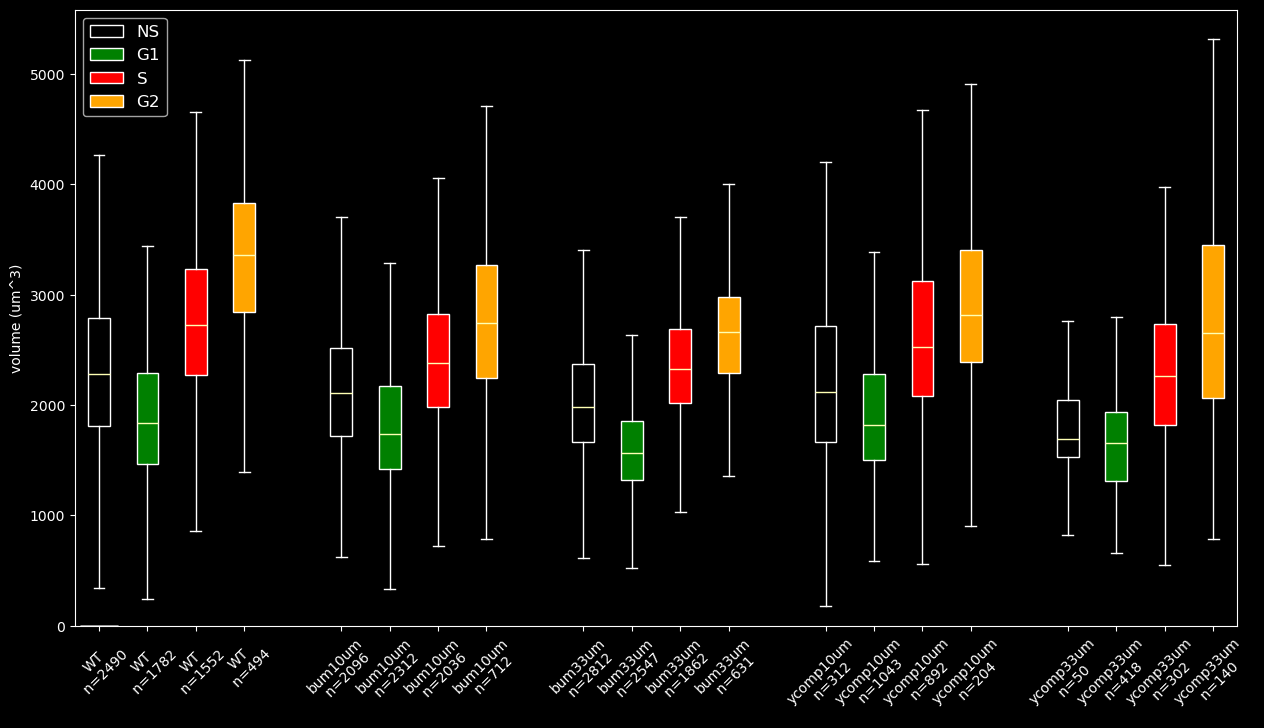

In [249]:
plt.figure(figsize=(15,8))
volume_boxplot([WT.volumes, bum10um.volumes, bum33um.volumes, ycomp10um.volumes, ycomp33um.volumes], ['WT', 'bum10um', 'bum33um', 'ycomp10um', 'ycomp33um'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\dilution_volume_boxplot.jpg', bbox_inches='tight', dpi=300)

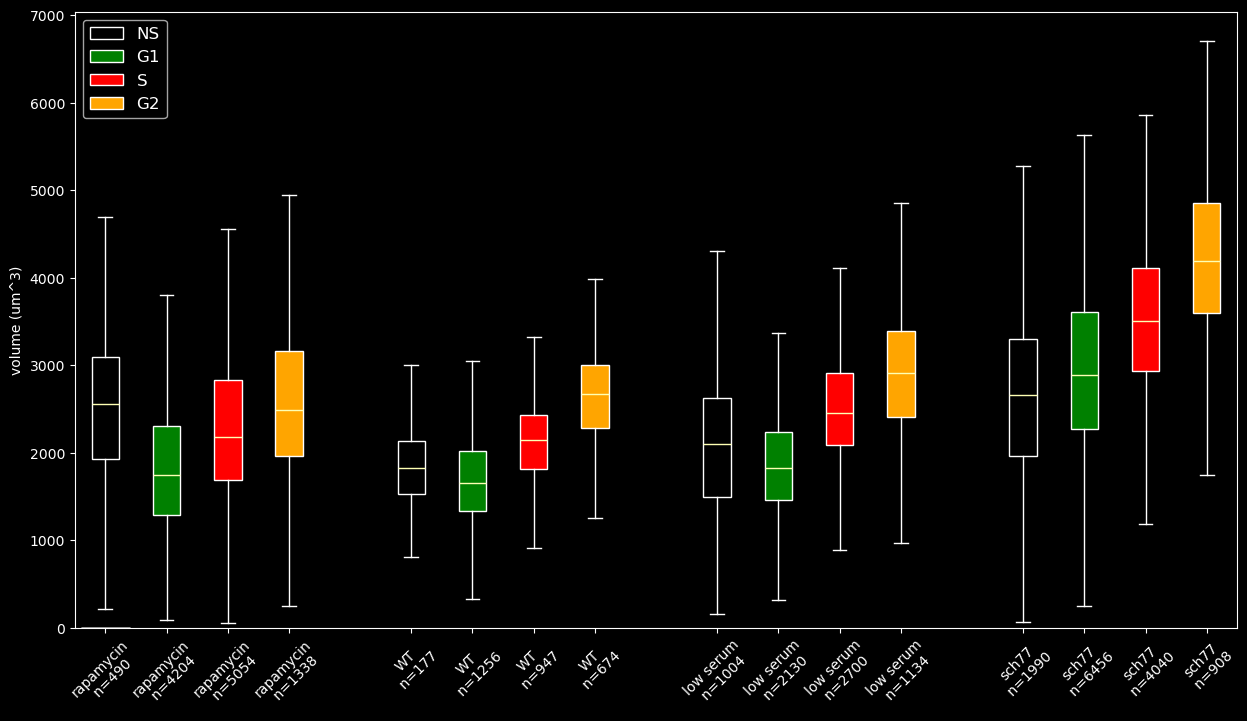

In [214]:
plt.figure(figsize=(15,8))
volume_boxplot([rapamycin.volumes, WT.volumes, low_serum.volumes, sch77.volumes], ['rapamycin', 'WT', 'low serum', 'sch77'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\volume_boxplot.jpg', bbox_inches='tight', dpi=300)

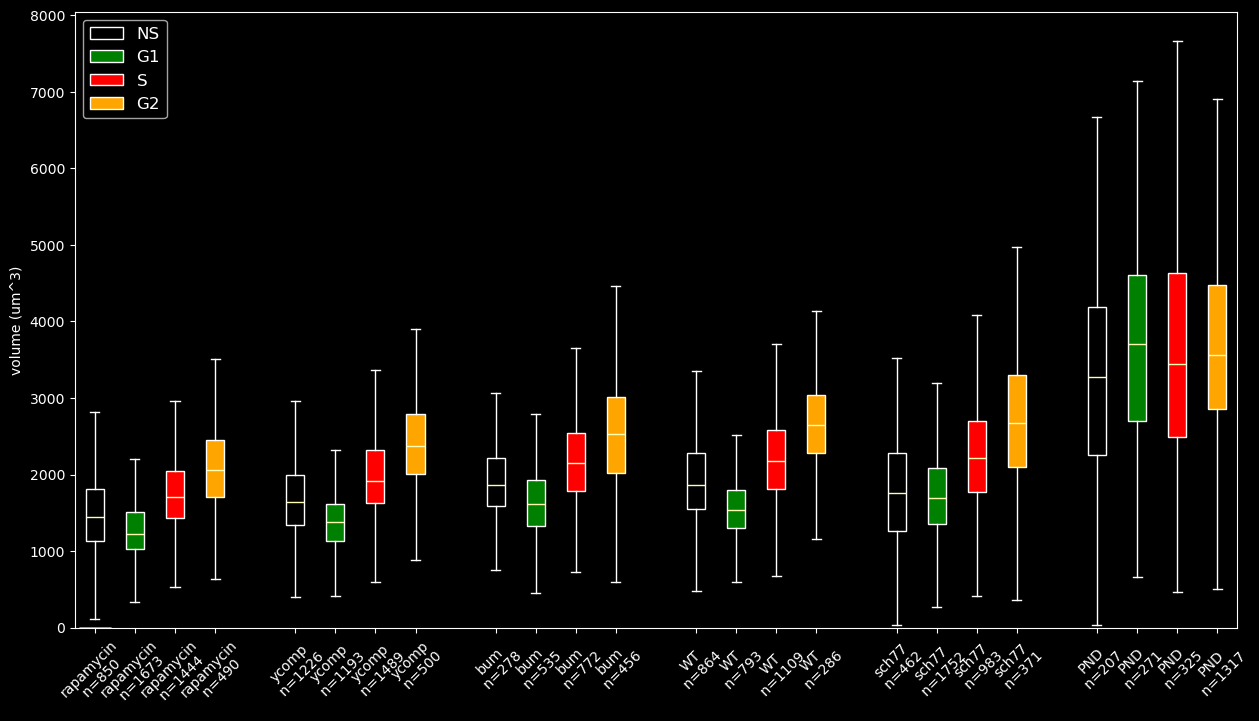

In [176]:
plt.figure(figsize=(15,8))
volume_boxplot([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\volume_boxplot.jpg', bbox_inches='tight', dpi=300)

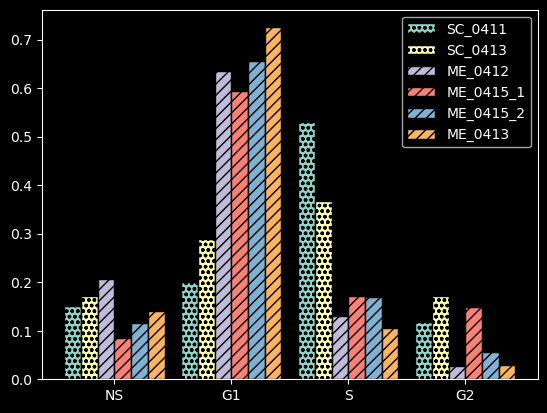

In [23]:
multi_barplot([vol_0411_SC, vol_0413_SC, vol_0412_ME, vol_0415_ME1, vol_0415_ME2, vol_0413_ME], ['SC_0411','SC_0413','ME_0412','ME_0415_1', 'ME_0415_2', 'ME_0413'], plt.gca())

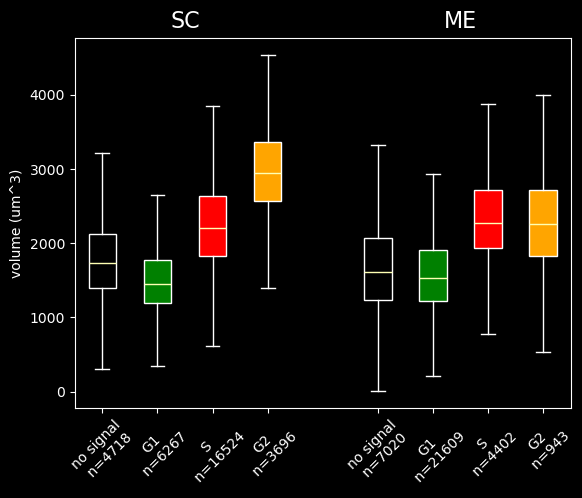

In [132]:
volumes=SC_0411.volumes+ME_0412.volumes
names=['no signal', 'G1', 'S', 'G2']*2
n_samples=[len(v) for v in volumes]

labels=[f"{name}\n n={n}" for name, n in zip(names, n_samples)]
colors=['k','g','r','orange']*2
bp=plt.boxplot(volumes, positions=[1,2,3,4,6,7,8,9],patch_artist=True, showfliers=False, labels=labels)
plt.xticks(rotation=45)
plt.ylabel('volume (um^3)')

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# label first group as subconfluent, second group as mature
plt.text(2.5, 4900, 'SC', fontsize=16, ha='center')
plt.text(7.5, 4900, 'ME', fontsize=16, ha='center')

fig.tight_layout()
#plt.savefig('plots/suspended_volumes/20240412 suspended volumes.jpg', bbox_inches='tight',dpi=300)

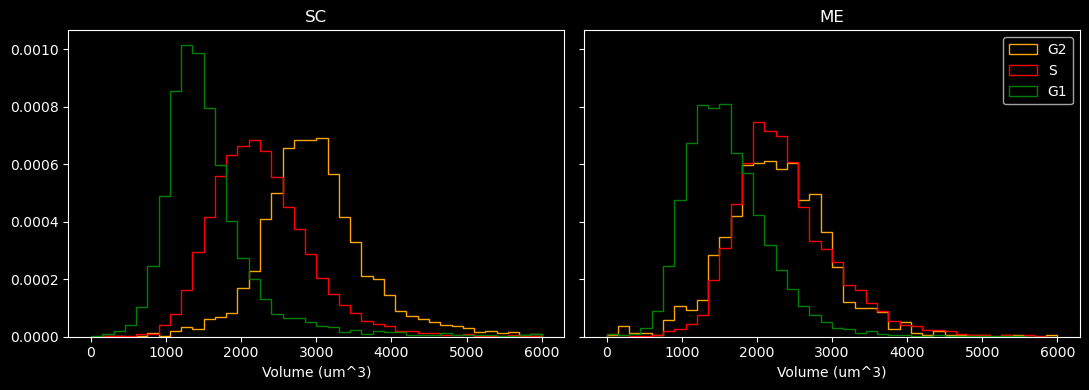

In [123]:
fig, axes=plt.subplots(1,2, figsize=(11,4), sharey=True)
axes[0].hist(SC_0411.volumes[1:], bins=40, range=(0,6000), density=True, histtype='step', label=['G1', 'S', 'G2'], color=['g','r','orange'])
axes[1].hist(ME_0412.volumes[1:], bins=40, range=(0,6000), density=True, histtype='step', label=['G1', 'S', 'G2'], color=['g','r','orange'])

axes[1].legend()

axes[0].set_title('SC')
axes[1].set_title('ME')

axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('Volume (um^3)')
fig.tight_layout()

plt.savefig('plots/suspended_volumes/FUCCI_volume_hist.jpg', dpi=300)

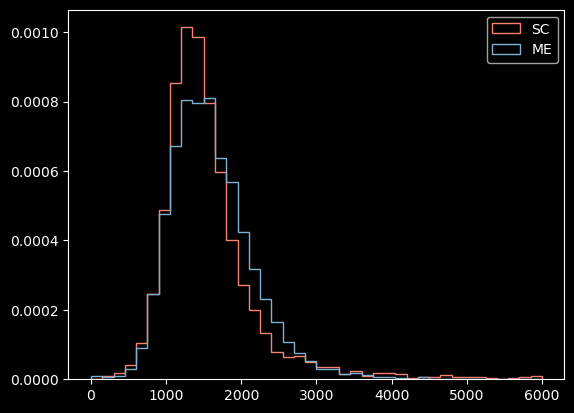

In [90]:
plt.hist(SC_0411.volumes[1], bins=40, range=(0,6000), density=True, histtype='step', label='SC', color='C3')
plt.hist(ME_0412.volumes[1], bins=40, range=(0,6000), density=True, histtype='step', label='ME', color='C4')
plt.legend()

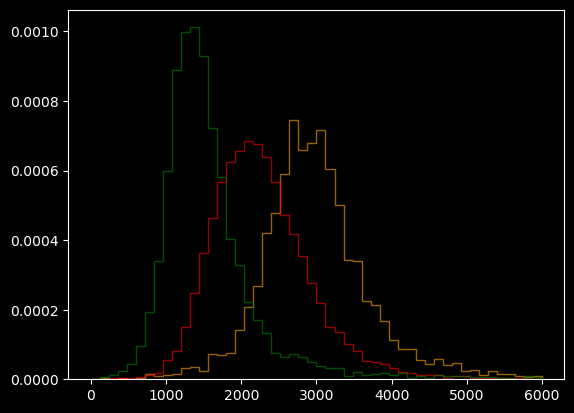

In [72]:
plt.hist(SC_0411.volumes[1:], color=['g','r','orange'], alpha=0.6, bins=50, range=(0,6000), density=True, histtype='step')
plt.show()

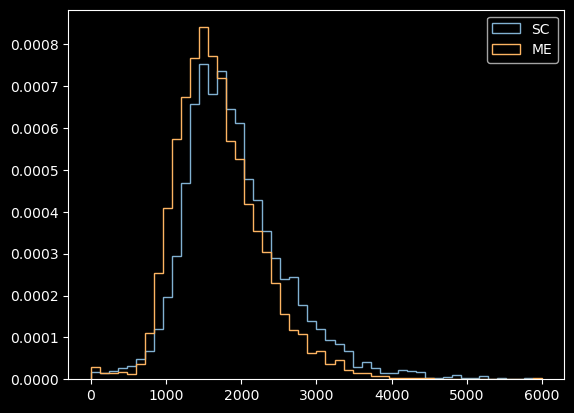

In [68]:
# plot G1 volumes for ME and SC as histograms
plt.hist(SC.volumes[1], bins=50, range=(0,6000), density=True, histtype='step', label='SC', color='C4')
plt.hist(ME.volumes[1], bins=50, range=(0,6000), density=True, histtype='step', label='ME', color='C5')

plt.legend()